# Benford's Analysis - Global Food Prices

This notebook was made to supplement one of my blogpost - [link](). Although, you'll be able to follow it along without reading the blogpost. You just need to know what Benford's law says. In this notebook, we'll see how to do a Benford's analysis and by doing so, we'll see if our dataset (historical temperatures of India) will follow the Benford's law.


## Index

1. [A basic exploration first](#exploration)
2. [Benford's Analysis](#benford)


## Dataset

My source of data was the mailing list I follow - [Data is Plural by Jeremy Singer-Vine](https://tinyletter.com/data-is-plural)

The UN World Food Programme’s [vulnerability analysis group][1] collects and publishes [food price data for more than 1,000 towns and cities in more than 70 countries][2]. The dataset, which goes back more than a decade, covers basic staples, such as wheat, rice, milk, oil, and more. It’s updated monthly and feeds into (among other things) the [UNWFP’s price-spike indicators][3].

[1]: http://vam.wfp.org/
[2]: https://data.humdata.org/dataset/wfp-food-prices
[3]: http://foodprices.vam.wfp.org/ALPS-at-a-glance.aspx



In [2]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
data_file = "Data/Food Prices/WFPVAM_FoodPrices_24-7-2017.csv"


In [5]:
data = pd.read_csv(data_file)
data.head()

,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_month,mp_year,mp_price,mp_commoditysource
0,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,1,2014,50.000,WFP
1,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,2,2014,50.000,WFP
2,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,3,2014,50.000,WFP
3,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,4,2014,50.000,WFP
4,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,5,2014,50.000,WFP


<a id='exploration'></a>
## 1. A basic exploration first

In [67]:
data.shape

(743914, 18)

So, our data has fairly good amount of records to perform Benford's analysis.

#### Columns

In [35]:
data.dtypes

adm0_id                 int64
adm0_name              object
adm1_id                 int64
adm1_name              object
mkt_id                  int64
mkt_name               object
cm_id                   int64
cm_name                object
cur_id                  int64
cur_name               object
pt_id                   int64
pt_name                object
um_id                   int64
um_name                object
mp_month                int64
mp_year                 int64
mp_price              float64
mp_commoditysource     object
dtype: object

#### Countries

In [73]:
print("All the countries present-")
data.adm0_name.unique()

All the countries present-


array(['Afghanistan', 'Algeria', 'Armenia', 'Azerbaijan', 'Bangladesh',
       'Benin', 'Bhutan', 'Bolivia', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Cape Verde', 'Central African Republic', 'Chad',
       'Colombia', 'Congo', 'Costa Rica', "Cote d'Ivoire",
       'Democratic Republic of the Congo', 'Djibouti', 'El Salvador',
       'Ethiopia', 'Gambia', 'Georgia', 'Ghana', 'Guatemala',
       'Guinea-Bissau', 'Guinea', 'Haiti', 'Honduras', 'India',
       'Indonesia', 'Iran  (Islamic Republic of)', 'Iraq', 'Jordan',
       'Kenya', 'Kyrgyzstan', "Lao People's Democratic Republic",
       'Lebanon', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali',
       'Mauritania', 'Mozambique', 'Myanmar', 'Nepal', 'Niger', 'Nigeria',
       'Pakistan', 'Panama', 'Peru', 'Philippines', 'Rwanda', 'Senegal',
       'Somalia', 'Sri Lanka', 'Swaziland', 'Syrian Arab Republic',
       'Tajikistan', 'Timor-Leste', 'Turkey', 'Uganda', 'Ukraine',
       'United Republic of Tanzania', 

Thats a total of 74 countries!

#### Items

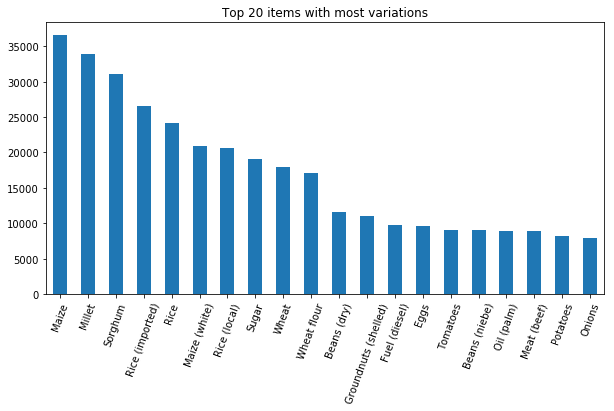

In [118]:
plt.figure(figsize=(10,5))
data.cm_name.value_counts().head(20).plot(kind='bar')
plt.xticks(rotation=70)
plt.title("Top 20 items with most variations")
plt.show()

In total there were 300+ food items in this list.

#### Year-wise collection

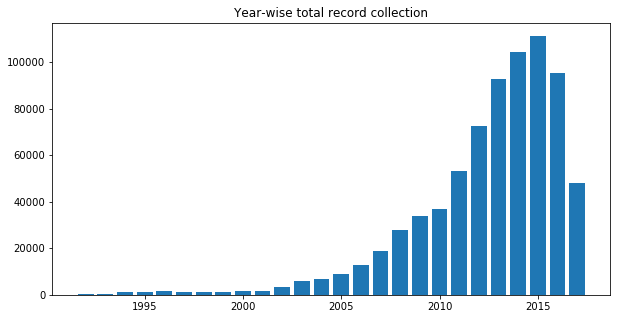

In [119]:
plt.figure(figsize=(10,5))
year_stats = data.mp_year.value_counts()
plt.bar(year_stats.index, year_stats)
plt.title("Year-wise total record collection")
plt.show()

I thought record collection count will keep increasing (or probably will come to a flat line) as the time progressed, but after a peak during 2015, it decreased in 2016 to a level of 2013. The year 2017 didn't get over at the time of writing this.

#### Prices

In [128]:
data.mp_price.describe()

count    743914.000
mean       4196.333
std       55492.958
min           0.000
25%          30.000
50%         175.000
75%         500.000
max     5833333.000
Name: mp_price, dtype: float64

The prices are distributed over a very large range. As can be seen above, **minimum is 0 units** and **maximum is 5.8 million units**.

For the curious ones, the items and country pairs where price is 0 units are-


In [83]:
minimums = data[['adm0_name', 'cm_name', 'mp_year']][data.mp_price == data.mp_price.min()].drop_duplicates()
minimums.columns = ["Country", "Items", "Year"]
pd.DataFrame(minimums.reset_index(drop=1))

,Country,Items,Year
0,Gambia,Fonio,2017
1,Jordan,Oranges (big size),2016
2,Lao People's Democratic Republic,Fish (snake head),2016
3,Lao People's Democratic Republic,Fish (snake head),2017
4,Syrian Arab Republic,Dates,2016
5,Syrian Arab Republic,Cheese,2016
6,Syrian Arab Republic,Parsley,2016
7,Tajikistan,Wage (qualified labour),2017
8,Tajikistan,"Wage (non-qualified labour, non-agricultural)",2017


I have zero idea what **Fonio** is. Entry 2 is wild -  **Fish (snake head)**. Entries 6th and 7th seems out of place. If they are not then Tajikistan is the place you can get a *really* cheap labour. I'll have to see the data to further drill down into it. But I am leaving that for some other time.

Lets see what the max price is for.

In [84]:
maximums = data[['adm0_name', 'cm_name', 'mp_year']][data.mp_price == data.mp_price.max()].drop_duplicates()
maximums.columns = ["Country", "Items", "Year"]
pd.DataFrame(maximums.reset_index(drop=1))

,Country,Items,Year
0,Afghanistan,"Livestock (sheep, one-year-old alive female)",2002


Meh, not that interesting.

Anyway, I shoud mention this, this highest price value may not be the highest monetary value in the dataset. All of these figures are given in the respective currencies of their country. And, I haven't converted the figures to a standard one yet. And, I won't. For Benford's Analysis, I want the data as *natural* as I can get.

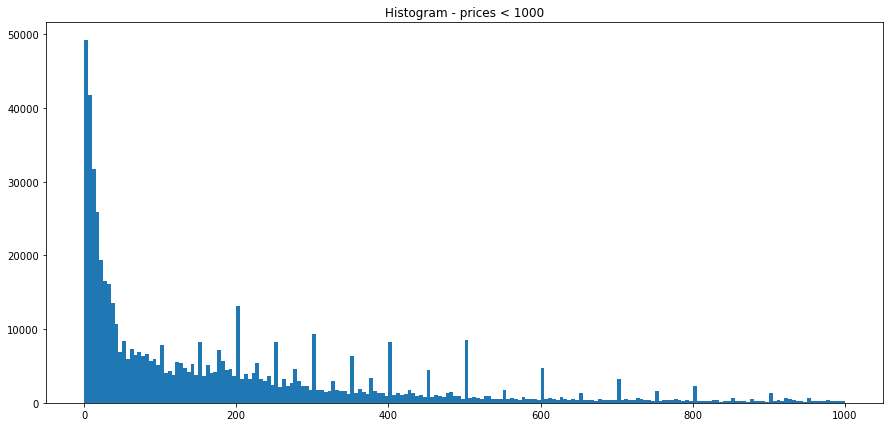

In [61]:
plt.figure(figsize=(15,7))
plt.hist(data.mp_price[data.mp_price < 1000], log=0, normed=0, bins=200)
plt.title("Histogram - prices < 1000")
plt.show()

The above plot shows a right skewed data with a very looooong right tail. In the plot I have capped the prices at 1000 units but it's going till 5 mill units. I am guessing, Benford's analysis will be accurate over this data.

<a id="benford"></a>
## 2. Benford's Analysis

First digit frequencies-

1   30.522
2   20.214
3   13.256
4    9.043
5    6.991
6    6.074
7    5.420
8    4.567
9    3.912
Name: mp_price, dtype: float64


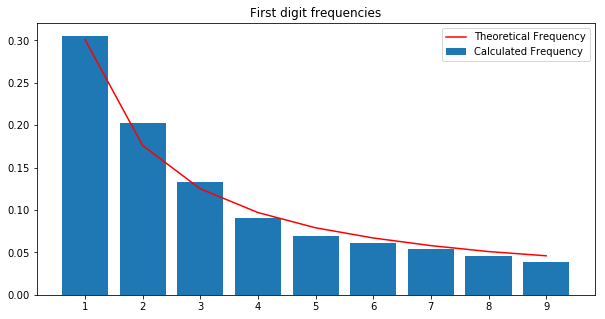

In [96]:
# First digit frequencies
freq = data.mp_price.astype(str).str.replace("-", "").str.lstrip("0").str.lstrip(".").str.lstrip("0").str[0].value_counts()
freq = freq/data.shape[0]
print("First digit frequencies-\n")
print(freq.sort_index()*100)

# First frequency digit plot
plt.figure(figsize=(10,5))
plt.bar(freq.index.astype(int), freq, label='Calculated Frequency')
plt.plot(range(1, 10), [0.301, 0.176, 0.125, 0.097, 0.079, 0.067, 0.058, 0.051, 0.046], c='red', label='Theoretical Frequency')
plt.legend(loc='upper right')
plt.title("First digit frequencies")
plt.xticks(freq.index.astype(int))
plt.show()

It does follow the Benford's law. Nice.

The source of this and other notebooks can be found in this Github repo - [Notebooks](https://github.com/TrigonaMinima/Notebooks).